# Feature engineering
### Stellar Classification Dataset - SDSS17
https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS\
alpha = Right Ascension angle (at J2000 epoch)\
delta = Declination angle (at J2000 epoch)\
u = Ultraviolet filter in the photometric system\
g = Green filter in the photometric system\
r = Red filter in the photometric system\
i = Near Infrared filter in the photometric system\
z = Infrared filter in the photometric system\
run_ID = Run Number used to identify the specific scan\
rereun_ID = Rerun Number to specify how the image was processed\
cam_col = Camera column to identify the scanline within the run\
field_ID = Field number to identify each field\
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)\
class = object class (galaxy, star or quasar object)\
redshift = redshift value based on the increase in wavelength\
plate = plate ID, identifies each plate in SDSS\
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken\
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation\

#### Citation
fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17.

Acknowledgements
The data released by the SDSS is under public domain. Its taken from the current data release RD17.

More information about the license: http://www.sdss.org/science/image-gallery/

### Wczytanie potrzebnych elementów i wstępna obróbka danych

Wczytanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn 

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Kod z https://stackoverflow.com/a/49199019 generujący zawartość requiments.txt
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for i in range(len(requirements)):
    print(f'{requirements[i][0]}=={requirements[i][1]}')

matplotlib==3.5.1
numpy==1.21.5
pandas==1.4.2
scikit-learn==1.0.2
seaborn==0.11.2
imblearn==0.0


Wczytanie i korekta ramki danych

In [3]:
# Wczytanie danych - dane do trenowania modelu
development_unit_df = pd.read_csv("..\\dane\\training_sample_team4.csv")

## Ramka danych walidacyjna dla zespołu budującego
test = pd.read_csv("..\\dane\\validation_sample_team4.csv")

## Ramka danych testowa dla zespołu walidującego
# test = pd.read_csv("..\\dane\\test_sample_team4.csv")


# Usuwanie kolumn, które są skorelowane z innymi ze współczynnikiem 1
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'rerun_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'obj_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'plate']

test = test.loc[:, test.columns != 'rerun_ID']
test = test.loc[:, test.columns != 'obj_ID']
test = test.loc[:, test.columns != 'plate']

# Usuwanie błędnej obserwacji
development_unit_df = development_unit_df[development_unit_df['u'] > 0]

development_unit_df.head()

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,MJD,fiber_ID
0,147.392648,0.145509,23.62785,21.78850,21.73961,21.88235,21.43752,1239,4,181,4.308885e+18,QSO,2.333820,55565,240
1,157.156740,35.327317,18.60880,17.52187,17.12905,16.95103,16.89711,4518,6,192,2.204664e+18,GALAXY,0.043298,53385,553
2,94.688025,63.535297,18.16716,16.51485,15.75641,15.35805,15.23041,5060,1,100,2.588464e+18,STAR,-0.000342,53711,74
3,214.420238,-1.506597,19.83027,18.47293,17.82672,17.48600,17.26200,2334,5,124,1.032563e+18,GALAXY,0.081886,52400,411
4,204.749167,17.703206,19.33024,18.16558,17.74244,17.48129,17.32534,5314,1,181,2.935343e+18,GALAXY,0.061780,54184,443


### Używane funkcje

In [36]:
def standard_distribution_info(variable_name, shareX):
    fig, ax = plt.subplots(4, 1, sharex=shareX, figsize=(10, 5))
    sns.histplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.histplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.histplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.histplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=0.0)
    fig.show()

def standard_boxplot_info(variable_name, show_text):
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 5))
    sns.boxplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.boxplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.boxplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.boxplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=0.0)
    fig.show()
    if (show_text):
        boxplot_info(variable_name)
    
def boxplot_info(variable_name):
    # outliery są znajdywane za pomocą metody 1.5IQR
    print('All classes:')
    selected_df = df[variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('GALAXY:')
    selected_df = df[df['class']=='GALAXY'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('QSO:')
    selected_df = df[df['class']=='QSO'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('STAR:')
    selected_df = df[df['class']=='STAR'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    
def standard_correlation_visualisation(variable_name, limit, show_text):
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[:5], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[5:10], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[10:15], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[15:18], hue='class')
    plt.show()
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    df_correlation[variable_name].plot.bar(color='#17becf', ylim=(-1, 1), ax=ax[0, 0]).set(title='All classes correlations') 
    df_correlation_GALAXY[variable_name].plot.bar(color='#1f77b4', ylim=(-1, 1), ax=ax[0, 1]).set(title='GALAXY correlations')
    df_correlation_QSO[variable_name].plot.bar(color='#ff7f0e', ylim=(-1, 1), ax=ax[1, 0]).set(title='QSO correlations')
    df_correlation_STAR[variable_name].plot.bar(color='#2ca02c', ylim=(-1, 1), ax=ax[1, 1]).set(title='STAR correlations')
    ax[0, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[0, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    ax[1, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[1, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    fig.tight_layout(pad=5.0)
    fig.show()
    if (show_text):
        print('korelacja:')
        print('all_classes: \n%s' %df_correlation.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('GALAXY: \n%s' %df_correlation_GALAXY.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('QSO: \n%s' %df_correlation_QSO.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('STAR: \n%s' %df_correlation_STAR.sort_values(by=[variable_name], ascending=False)[variable_name])
        
def test_models(df_train, df_test, show_details):
    
    X_train = df_train.drop('class', axis = 1)
    X_test = df_test.drop('class', axis = 1)
    
    y_train = df_train['class']
    y_test = df_test['class']
    
    print('Dokładności modeli:')
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("LogisticRegression", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("KNeighborsClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("RandomForestClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("DecisionTreeClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    # Dla dużej liczby kolumn ten model długo pracuje, dlatego został sprawdzony tylo dla ostatnich wyników.
#     model = svm.SVC(kernel='linear')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print("SVC:", accuracy)
#     if(show_details):
#         print(classification_report(y_test, y_pred))
    
    model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("MLPClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))

def test_models_train_on_balanced(df_train, df_test, show_details):
    
    y = df_train['class']
    df_train = df_train.drop('class', axis=1)
    smote = SMOTE()
    df_train, y_resampled = smote.fit_resample(df_train, y)
    df_train['class'] = pd.DataFrame(y_resampled)
    
    X_train = df_train.drop('class', axis = 1)
    X_test = df_test.drop('class', axis = 1)
    
    y_train = df_train['class']
    y_test = df_test['class']
    
    print('Dokładności modeli:')
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("LogisticRegression", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("KNeighborsClassifier", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("RandomForestClassifier", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("DecisionTreeClassifier", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))
    
    # Dla dużej liczby kolumn ten model długo pracuje, dlatego został sprawdzony tylo dla ostatnich wyników.
#     model = svm.SVC(kernel='linear')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print("SVC:", accuracy)
#     if(show_details):
#         print(classification_report(y_test, y_pred))
    
    model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("MLPClassifier:", accuracy)
    if(show_details):
        print(classification_report(y_test, y_pred))


# Inżynieria cech

### Pierwsza iteracja

In [5]:
df = development_unit_df.copy()

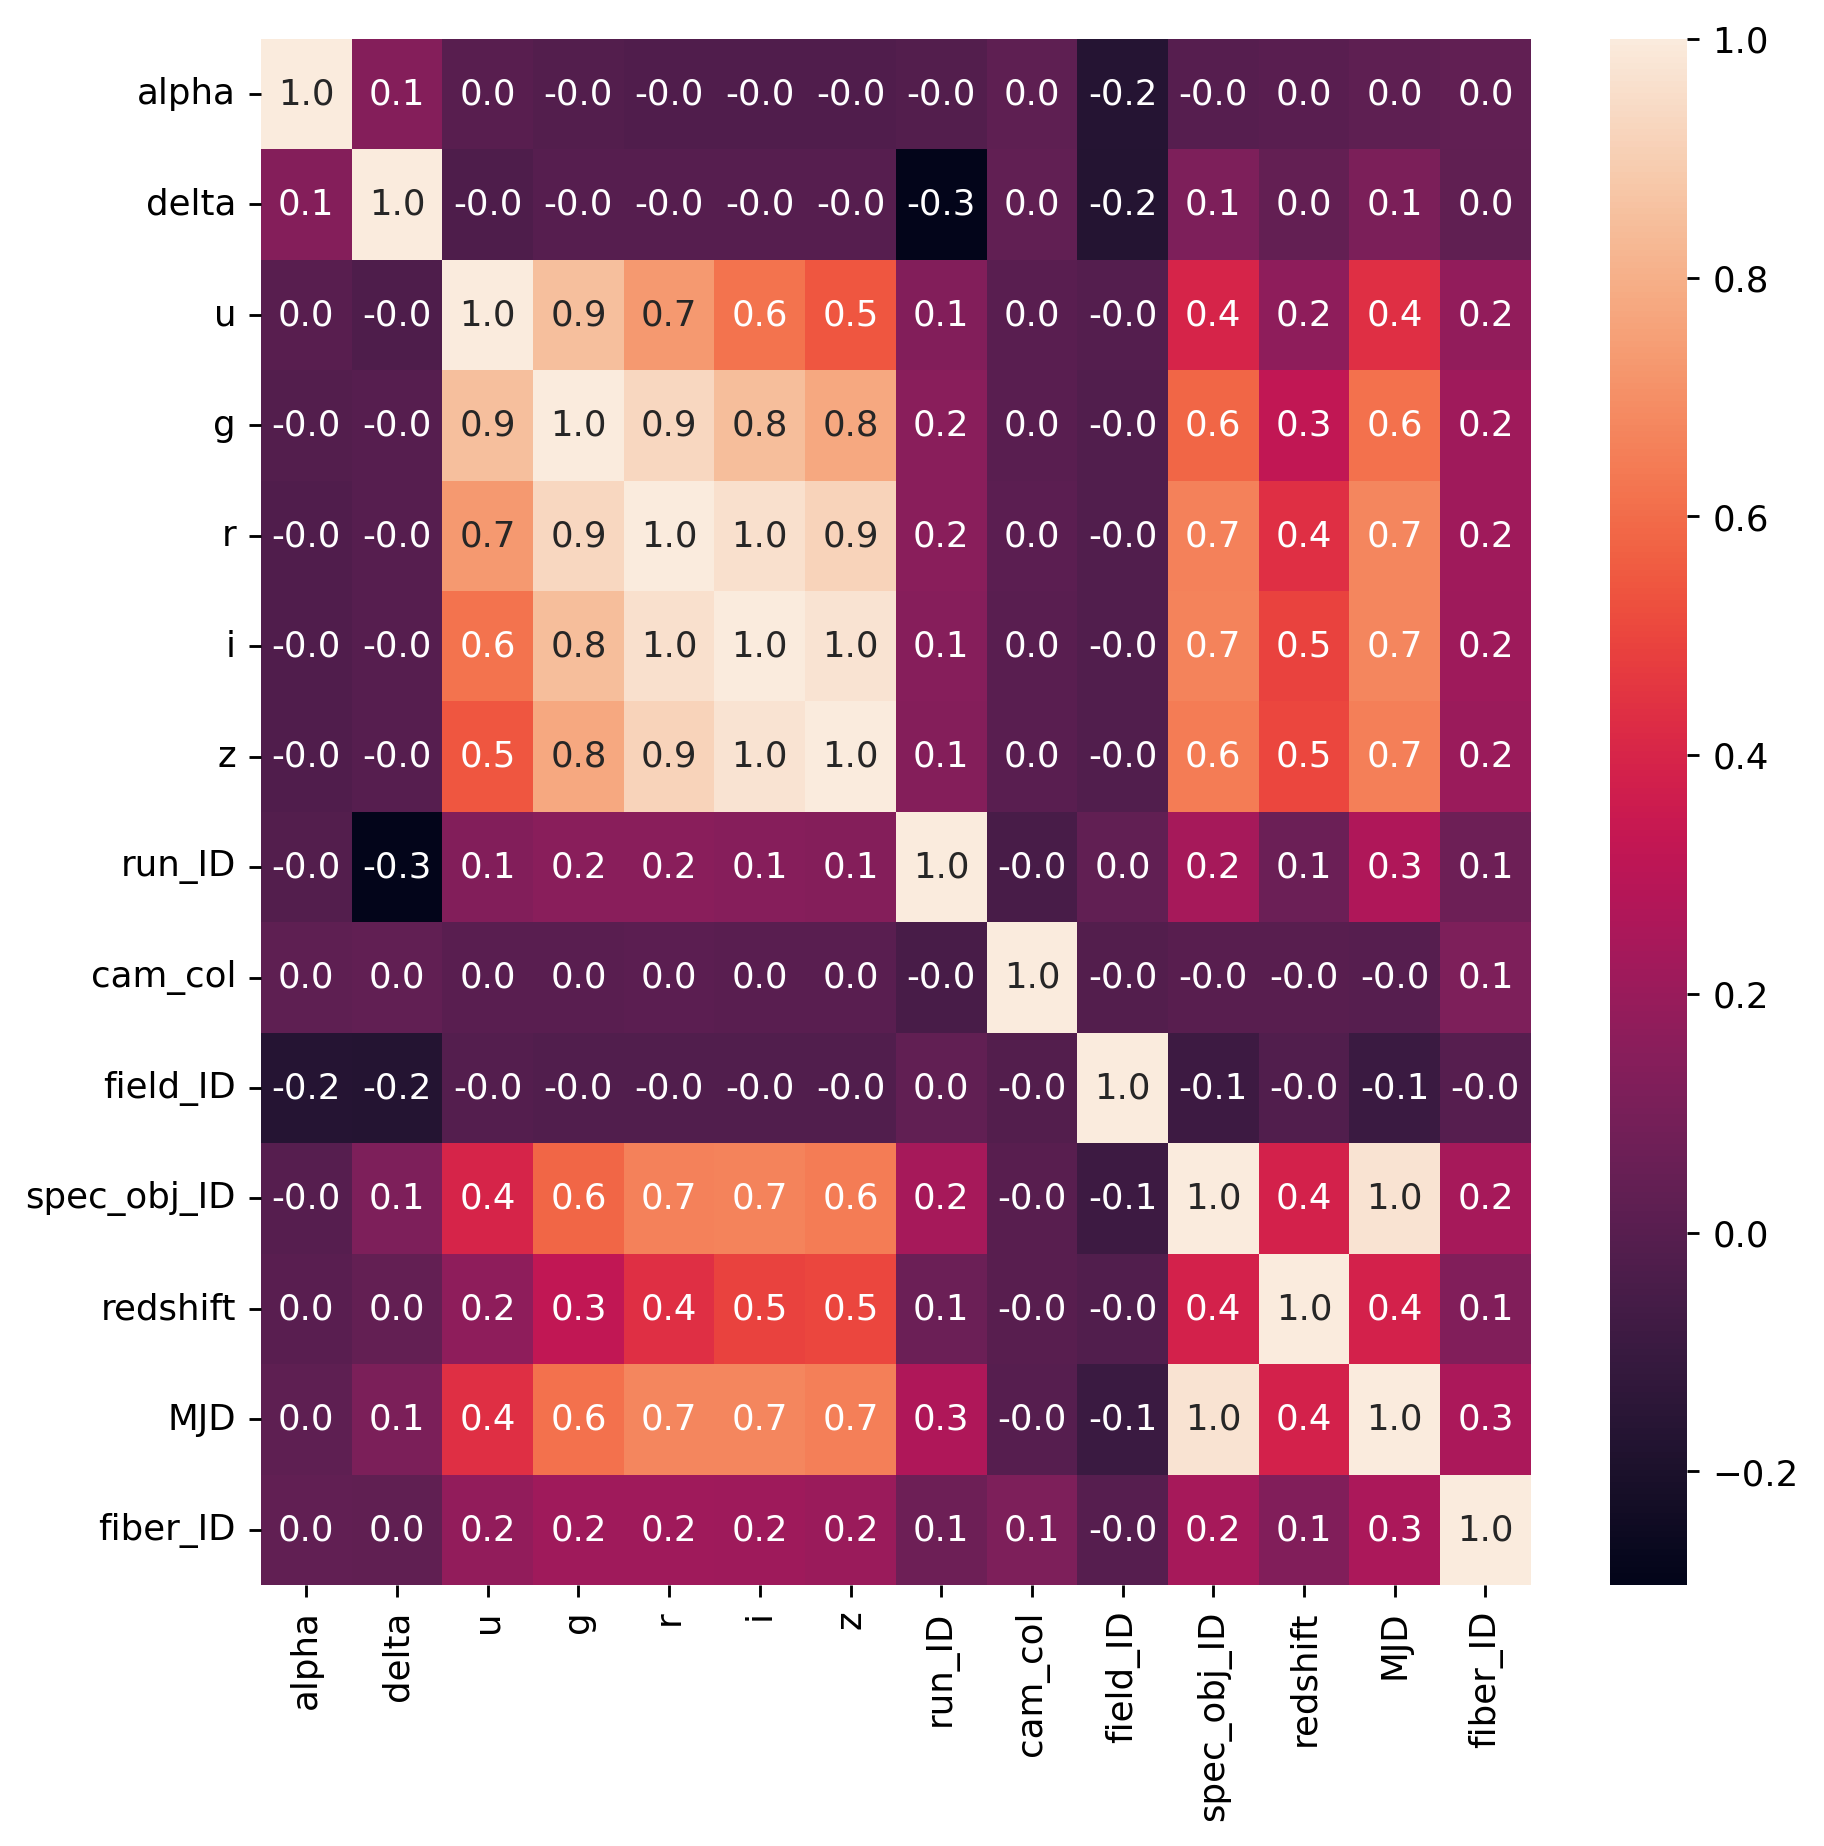

In [6]:
## jeszcze raz macierz korelacji -> widzimy, że usunęliśmy najbardziej skorelowane kolumny
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

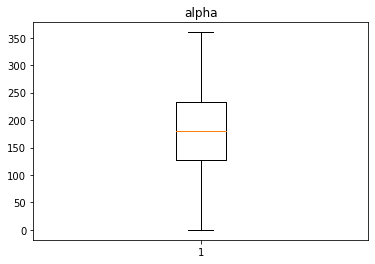

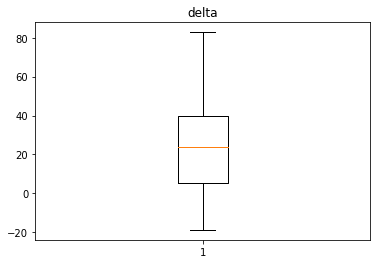

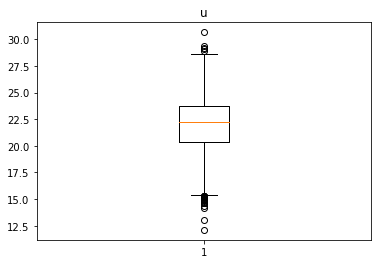

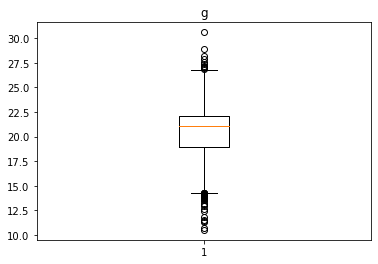

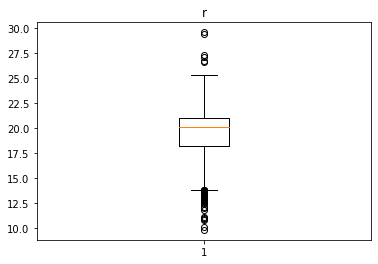

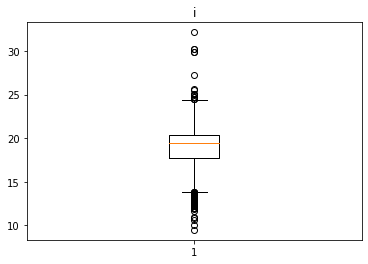

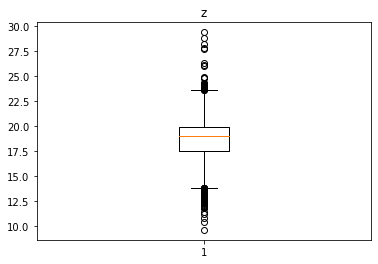

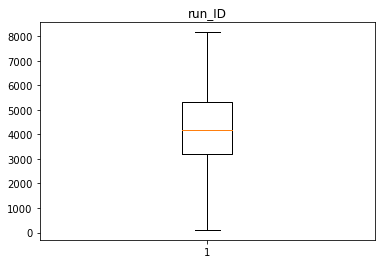

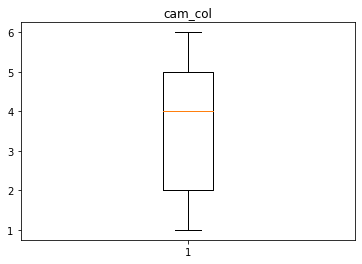

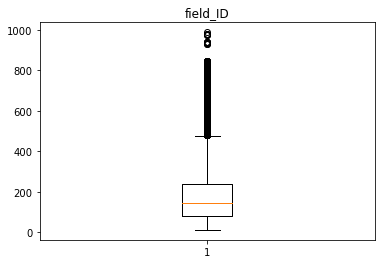

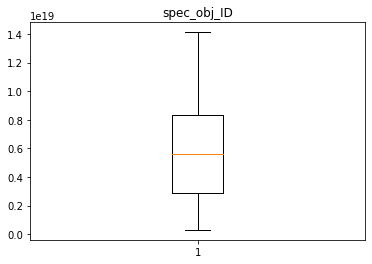

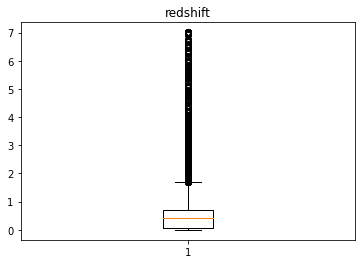

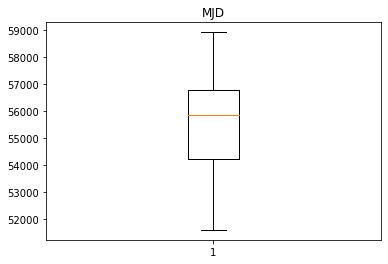

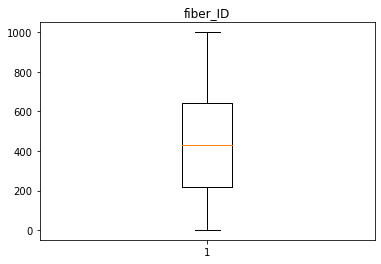

In [7]:
## usuwanie OUTLIERS: zobaczmy, dla których zmiennych wystąpują wartości odstające
for i in range(15):
    if i != 11:
        plt.boxplot(df.iloc[:, i])
        plt.title(df.columns[i])
        plt.show()

In [8]:
### przyjrzyjmy się outlierom w kolumnach 'u', 'r' jeszcze raz:
columns_to_be_checked = ['r', 'u']

for i in range(len(columns_to_be_checked)):
    column = df[columns_to_be_checked[i]]
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)

    IQR = Q3 - Q1

    outliers = (column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))

    outliers_count = outliers.sum()

    outliers_percentage = outliers.mean() * 100
    df = df[~outliers]
    print(outliers_count)
    print("Ilość outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_count)
    print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_percentage)
    
    ## usuńmy outliery dla u i r: stanowią tylko 0.13% i 0.03% wszystkich wierszy

63
Ilość outlierów dla kolumny  r :  63
Procentowy udział outlierów dla kolumny  r :  0.12857142857142856
13
Ilość outlierów dla kolumny  u :  13
Procentowy udział outlierów dla kolumny  u :  0.026564766945256148


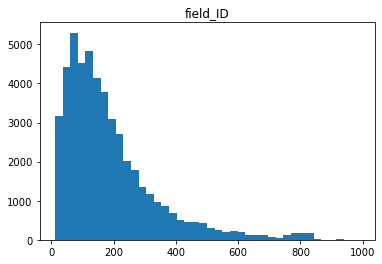

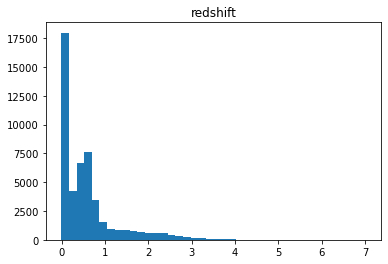

In [9]:
### spójrzmy jeszcze na dwie pozostałe kolumny z outlierami:

plt.hist(df.iloc[:, 9], bins = 40)
plt.title(df.columns[9])
plt.show()

plt.hist(df.iloc[:, 12], bins = 40)
plt.title(df.columns[12])
plt.show()

# zmienne redshift oraz filed_ID mają rozkład wykładniczy

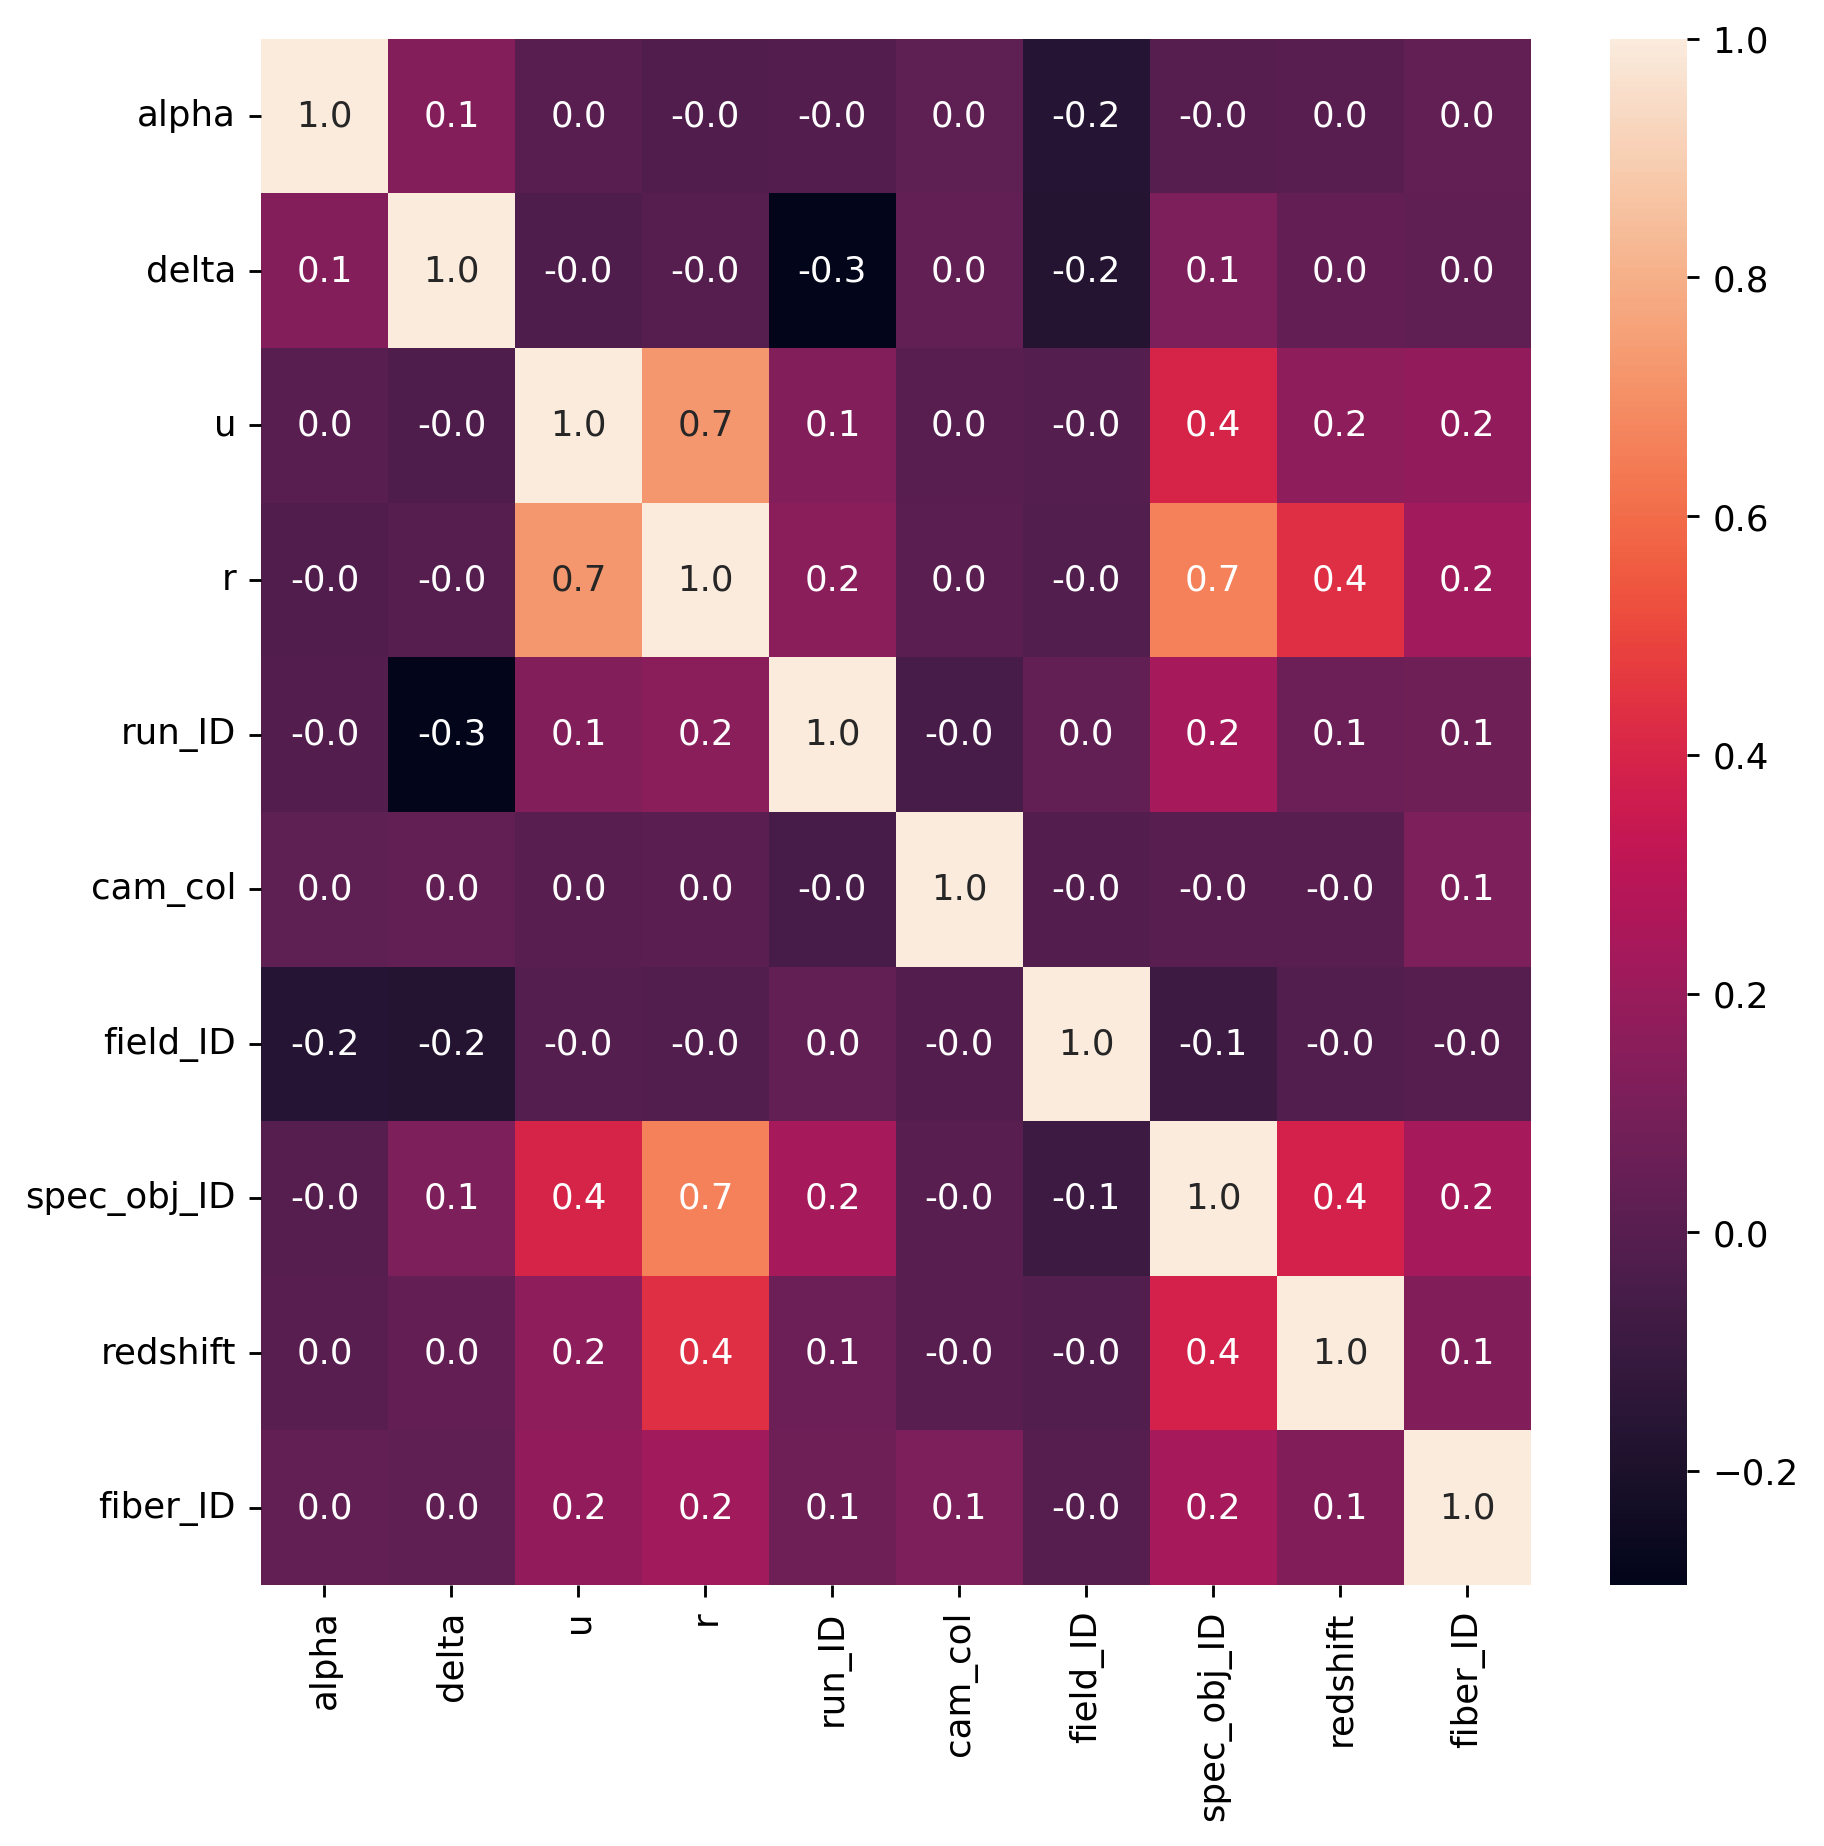

In [10]:
df = df.drop(['i', 'g', 'z', 'MJD'], axis = 1)
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

In [11]:
df.head()

,alpha,delta,u,r,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,fiber_ID
0,147.392648,0.145509,23.62785,21.73961,1239,4,181,4.308885e+18,QSO,2.333820,240
1,157.156740,35.327317,18.60880,17.12905,4518,6,192,2.204664e+18,GALAXY,0.043298,553
2,94.688025,63.535297,18.16716,15.75641,5060,1,100,2.588464e+18,STAR,-0.000342,74
3,214.420238,-1.506597,19.83027,17.82672,2334,5,124,1.032563e+18,GALAXY,0.081886,411
4,204.749167,17.703206,19.33024,17.74244,5314,1,181,2.935343e+18,GALAXY,0.061780,443


In [12]:
### modyfikacja test:
test1 = test.copy()
test1 = test1.drop(['i', 'g', 'z', 'MJD'], axis = 1)

# Normalizacja
columns_to_standardize = ['run_ID', 'fiber_ID', 'alpha', 'delta', 'redshift', 'spec_obj_ID', 'cam_col', 'u', 'r', 'field_ID']
df[columns_to_standardize] = MinMaxScaler().fit_transform(df[columns_to_standardize])
test1[columns_to_standardize] = MinMaxScaler().fit_transform(test1[columns_to_standardize])

# Standaryzacja
columns_to_normalize = ['u']
df[columns_to_normalize] = StandardScaler().fit_transform(df[columns_to_normalize])
test1[columns_to_normalize] = StandardScaler().fit_transform(test1[columns_to_normalize])

# Informacje o ramce danych
df.describe()

,alpha,delta,u,r,run_ID,cam_col,field_ID,spec_obj_ID,redshift,fiber_ID
count,48924.000000,48924.000000,4.892400e+04,48924.000000,48924.000000,48924.000000,48924.000000,48924.000000,48924.000000,48924.000000
mean,0.493419,0.422321,-1.131327e-16,0.506225,0.542871,0.502048,0.178614,0.397796,0.083262,0.448486
std,0.267958,0.193325,1.000010e+00,0.159802,0.243666,0.317433,0.152443,0.240511,0.104003,0.272877
min,0.000000,0.000000,-3.001102e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.354767,0.236484,-7.734140e-01,0.376506,0.382218,0.200000,0.071575,0.184754,0.008955,0.219219
50%,0.502022,0.417664,4.171036e-02,0.547680,0.506519,0.600000,0.138037,0.384899,0.061643,0.430430
75%,0.649566,0.576856,7.180954e-01,0.626408,0.647833,0.800000,0.234151,0.581395,0.101483,0.644645
max,1.000000,1.000000,2.906597e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Testowanie

In [13]:
test_models_train_on_balanced(df, test1, True)

Dokładności modeli:
LogisticRegression 0.8496666666666667
              precision    recall  f1-score   support

      GALAXY       0.97      0.78      0.86     12538
         QSO       0.89      0.91      0.90      3973
        STAR       0.65      1.00      0.79      4489

    accuracy                           0.85     21000
   macro avg       0.84      0.90      0.85     21000
weighted avg       0.89      0.85      0.85     21000

KNeighborsClassifier 0.7601428571428571
              precision    recall  f1-score   support

      GALAXY       0.87      0.75      0.81     12538
         QSO       0.73      0.84      0.78      3973
        STAR       0.57      0.71      0.63      4489

    accuracy                           0.76     21000
   macro avg       0.72      0.77      0.74     21000
weighted avg       0.78      0.76      0.77     21000

RandomForestClassifier 0.9665714285714285
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.97

### Wnioski
- przy zamianie outlierow z kolumn field_ID, redshift lub ich usunięciu, dokładności przykładowych 
modeli spadają do około 40 - 50 %
- normalizacja przed standaryzacją daje gorsze wyniki, bez standaryzacji zmiennej u też są gorsze wyniki
- można się jeszcze zastanowić nad usunięciem zmiennej 'r' ponieważ ma ona korelację z zmienną 'u' równą 0.73 
(co jest dosyć sporo) + bez tej zmiennej model ma porównywalną precyzyjność

## Macierz korelacji dla ramki bez modefiakcji

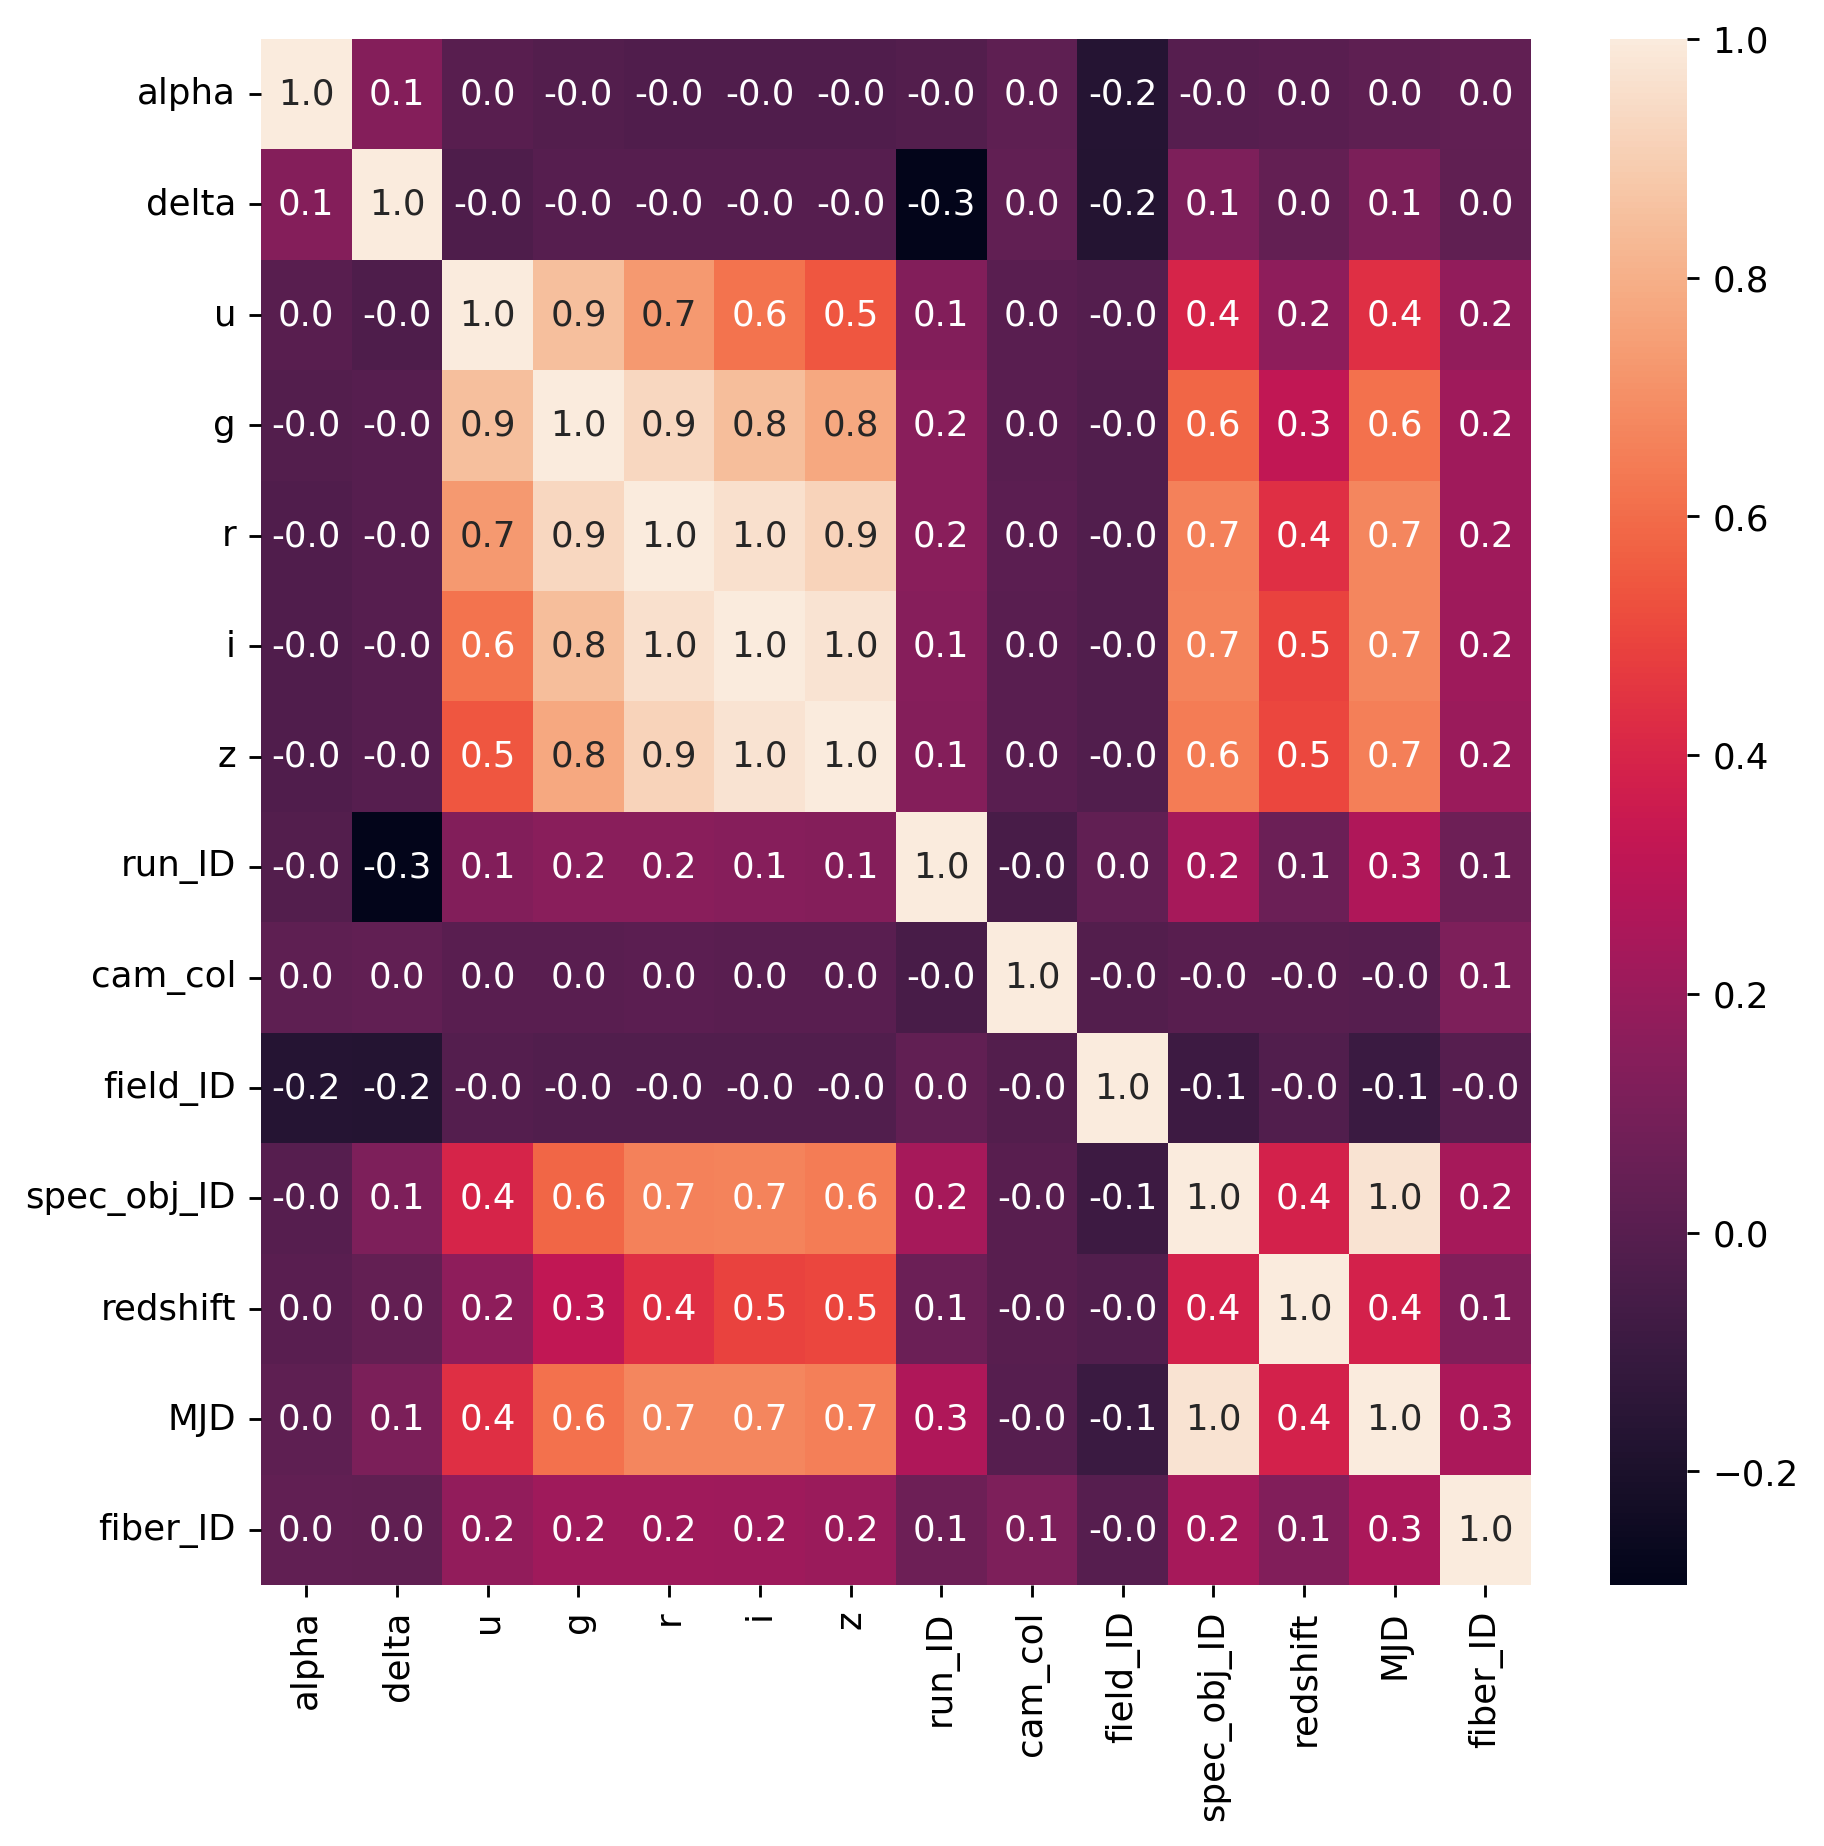

In [14]:
df = development_unit_df.copy()
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

Standaryzacja jest zalecana dla cech o rozkładzie podobnym do narmalnego i zawierających wartości odstające.
Do tych kolumn należą:rerun obj plate
- delta
- u
- g
- r
- i
- z
- redshift
- field_ID

Pozostałe można poddać normalizacji:
- alpha
- run_ID 
- cam_col
- spec_obj_ID
- MJD
- fiber_ID

## Bez modefikacji

In [15]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test2 = test.copy()

# Modefikowanie cech

# Usuwanie kolumn

# Korekta outlierów

# Normalizacja

# Standaryzacja

# Informacje o ramce danych

# Testowanie
test_models(df, test2, True)

Dokładności modeli:
LogisticRegression 0.597047619047619
              precision    recall  f1-score   support

      GALAXY       0.60      1.00      0.75     12538
         QSO       0.00      0.00      0.00      3973
        STAR       0.00      0.00      0.00      4489

    accuracy                           0.60     21000
   macro avg       0.20      0.33      0.25     21000
weighted avg       0.36      0.60      0.45     21000

KNeighborsClassifier: 0.7056190476190476
              precision    recall  f1-score   support

      GALAXY       0.74      0.89      0.81     12538
         QSO       0.50      0.39      0.44      3973
        STAR       0.75      0.48      0.58      4489

    accuracy                           0.71     21000
   macro avg       0.66      0.58      0.61     21000
weighted avg       0.70      0.71      0.69     21000

RandomForestClassifier: 0.9761428571428571
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.9

## Usunięcie silnie skorelowanych kolumn

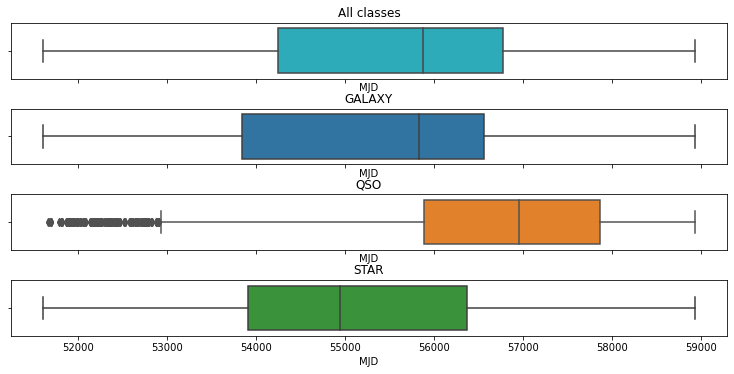

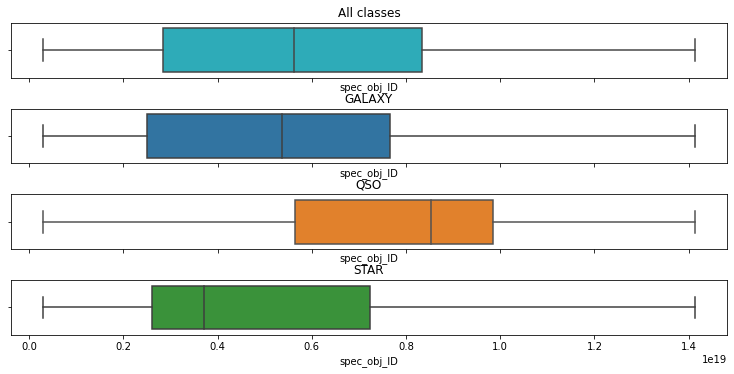

In [16]:
df = development_unit_df.copy()
standard_boxplot_info('MJD', False)
standard_boxplot_info('spec_obj_ID', False)

In [17]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test3 = test.copy()

# Modefikowanie cech

# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1) # korelacja =~1 z spec_obj_ID, lepsze wyniki testów z daną zmienną mieszczą się w granicach niepewności 
df = df.drop(['g', 'r', 'i', 'z'], axis = 1)

test3 = test3.drop(['MJD'], axis = 1) # korelacja =~1 z spec_obj_ID, lepsze wyniki testów z daną zmienną mieszczą się w granicach niepewności 
test3 = test3.drop(['g', 'r', 'i', 'z'], axis = 1)

# Korekta outlierów

# Normalizacja

# Standaryzacja

# Informacje o ramce danych

test_models(df, test3, False)

Dokładności modeli:
LogisticRegression 0.597047619047619
KNeighborsClassifier: 0.7056190476190476
RandomForestClassifier: 0.9742857142857143
DecisionTreeClassifier: 0.9577619047619048
MLPClassifier: 0.597047619047619


## Usunięcie silnie skorelowanych cech + normalizacja/standaryzacja

In [18]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test4 = test.copy()

# Modefikowanie cech

# Korekta outlierów

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test4[columns_to_normalize] = MinMaxScaler().fit_transform(test4[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID',]
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test4[columns_to_standardize] = StandardScaler().fit_transform(test4[columns_to_standardize])

# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['g', 'r', 'i', 'z'], axis = 1)
test4 = test4.drop(['MJD'], axis = 1)
test4 = test4.drop(['g', 'r', 'i', 'z'], axis = 1)


df.describe()

,alpha,delta,u,run_ID,cam_col,field_ID,spec_obj_ID,redshift,fiber_ID
count,49000.000000,4.900000e+04,4.900000e+04,49000.000000,49000.000000,4.900000e+04,49000.000000,4.900000e+04,49000.000000
mean,0.493339,-6.888396e-17,3.651229e-16,0.542763,0.502008,-9.223914e-17,0.397448,6.976024e-17,0.448352
std,0.267881,1.000010e+00,1.000010e+00,0.243571,0.317456,1.000010e+00,0.240544,1.000010e+00,0.272798
min,0.000000,-2.185018e+00,-4.436972e+00,0.000000,0.000000,-1.171868e+00,0.000000,-7.997699e-01,0.000000
25%,0.354669,-9.609356e-01,-7.686591e-01,0.382218,0.200000,-7.022165e-01,0.184433,-7.155145e-01,0.219219
50%,0.501978,-2.359948e-02,4.340899e-02,0.506519,0.600000,-2.661117e-01,0.384492,-2.084833e-01,0.430430
75%,0.649511,7.995564e-01,7.167467e-01,0.647833,0.800000,3.645630e-01,0.581328,1.752433e-01,0.643644
max,1.000000,2.987911e+00,3.800020e+00,1.000000,1.000000,5.389832e+00,1.000000,8.818612e+00,1.000000


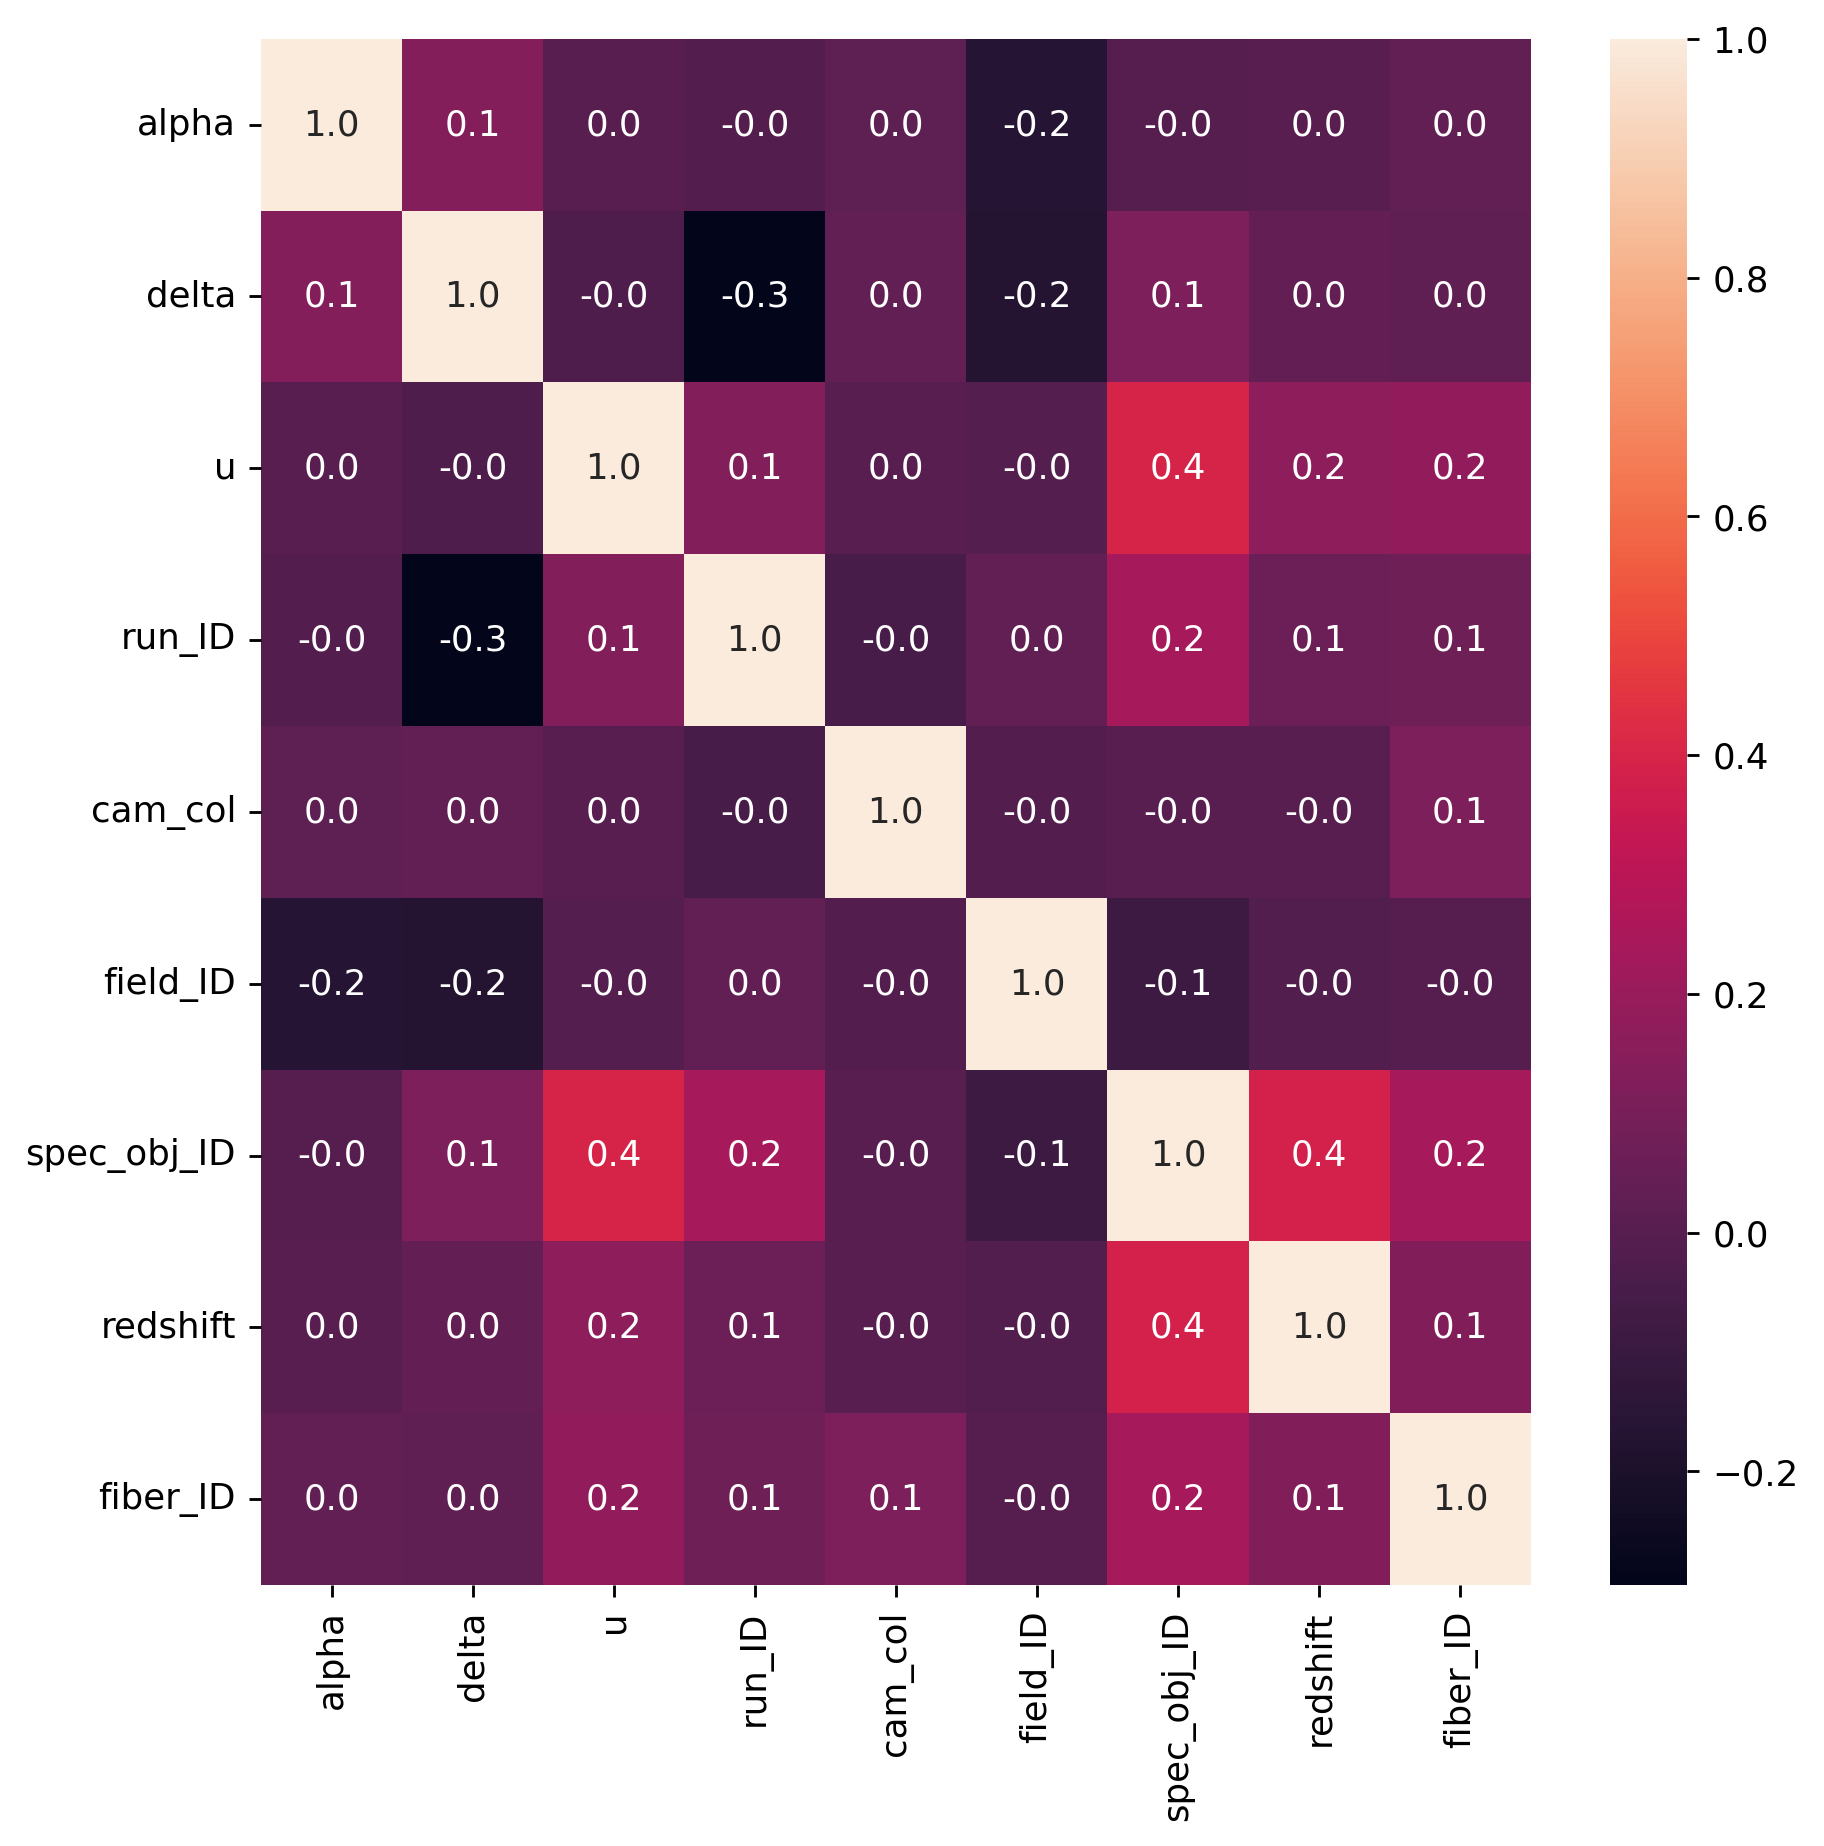

In [19]:
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

In [20]:
test_models(df, test4, False)

Dokładności modeli:
LogisticRegression 0.9516666666666667
KNeighborsClassifier: 0.918
RandomForestClassifier: 0.9686666666666667
DecisionTreeClassifier: 0.9050952380952381
MLPClassifier: 0.9634761904761905


### Modefikacja cech opisujących filtry

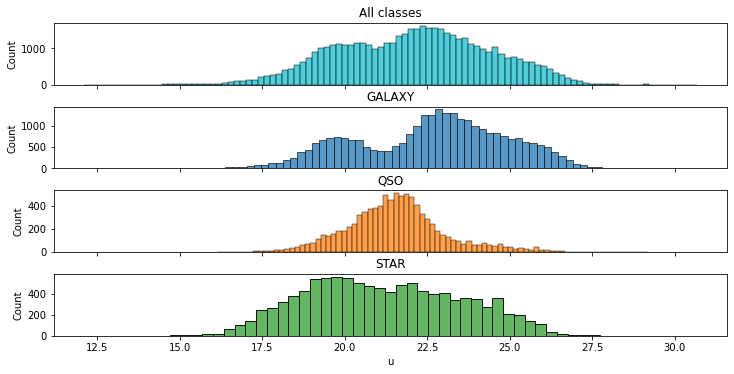

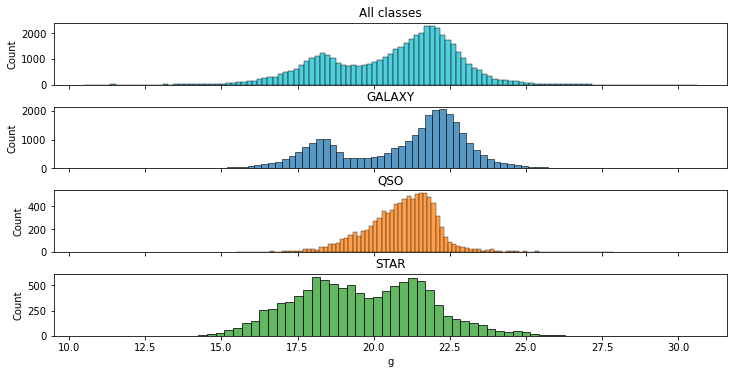

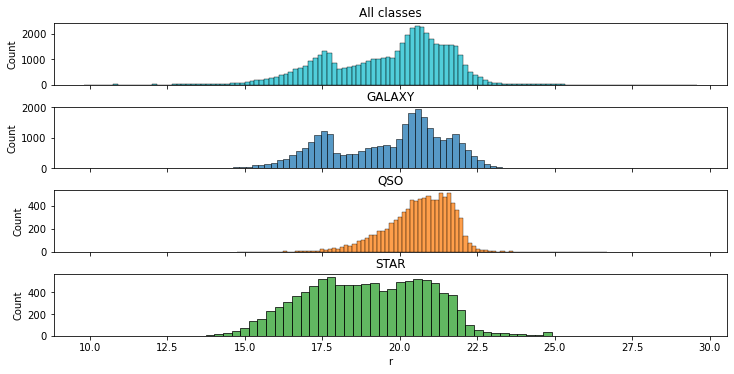

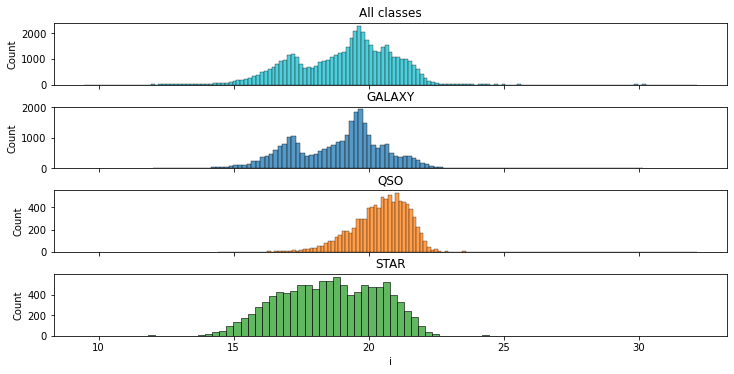

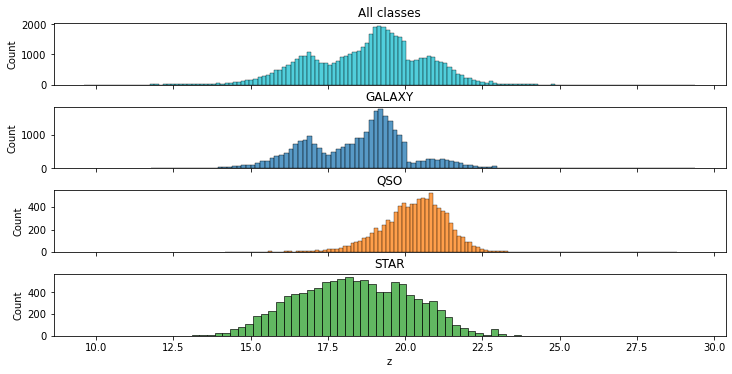

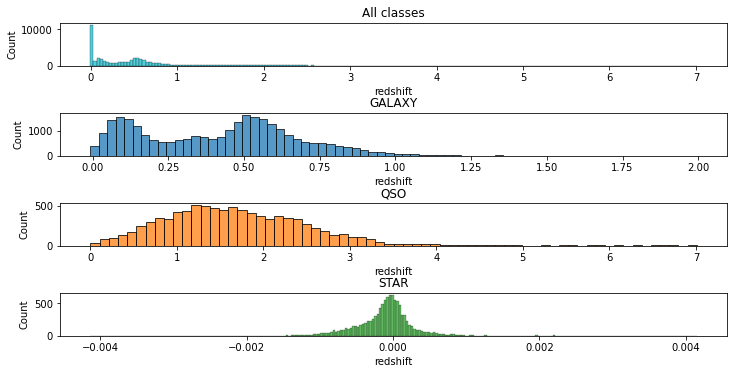

In [21]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test5 = test.copy()

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test5[columns_to_normalize] = MinMaxScaler().fit_transform(test5[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID',]
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test5[columns_to_normalize] = MinMaxScaler().fit_transform(test5[columns_to_normalize])

standard_distribution_info('u', True)
standard_distribution_info('g', True)
standard_distribution_info('r', True)
standard_distribution_info('i', True)
standard_distribution_info('z', True)
standard_distribution_info('redshift', False)

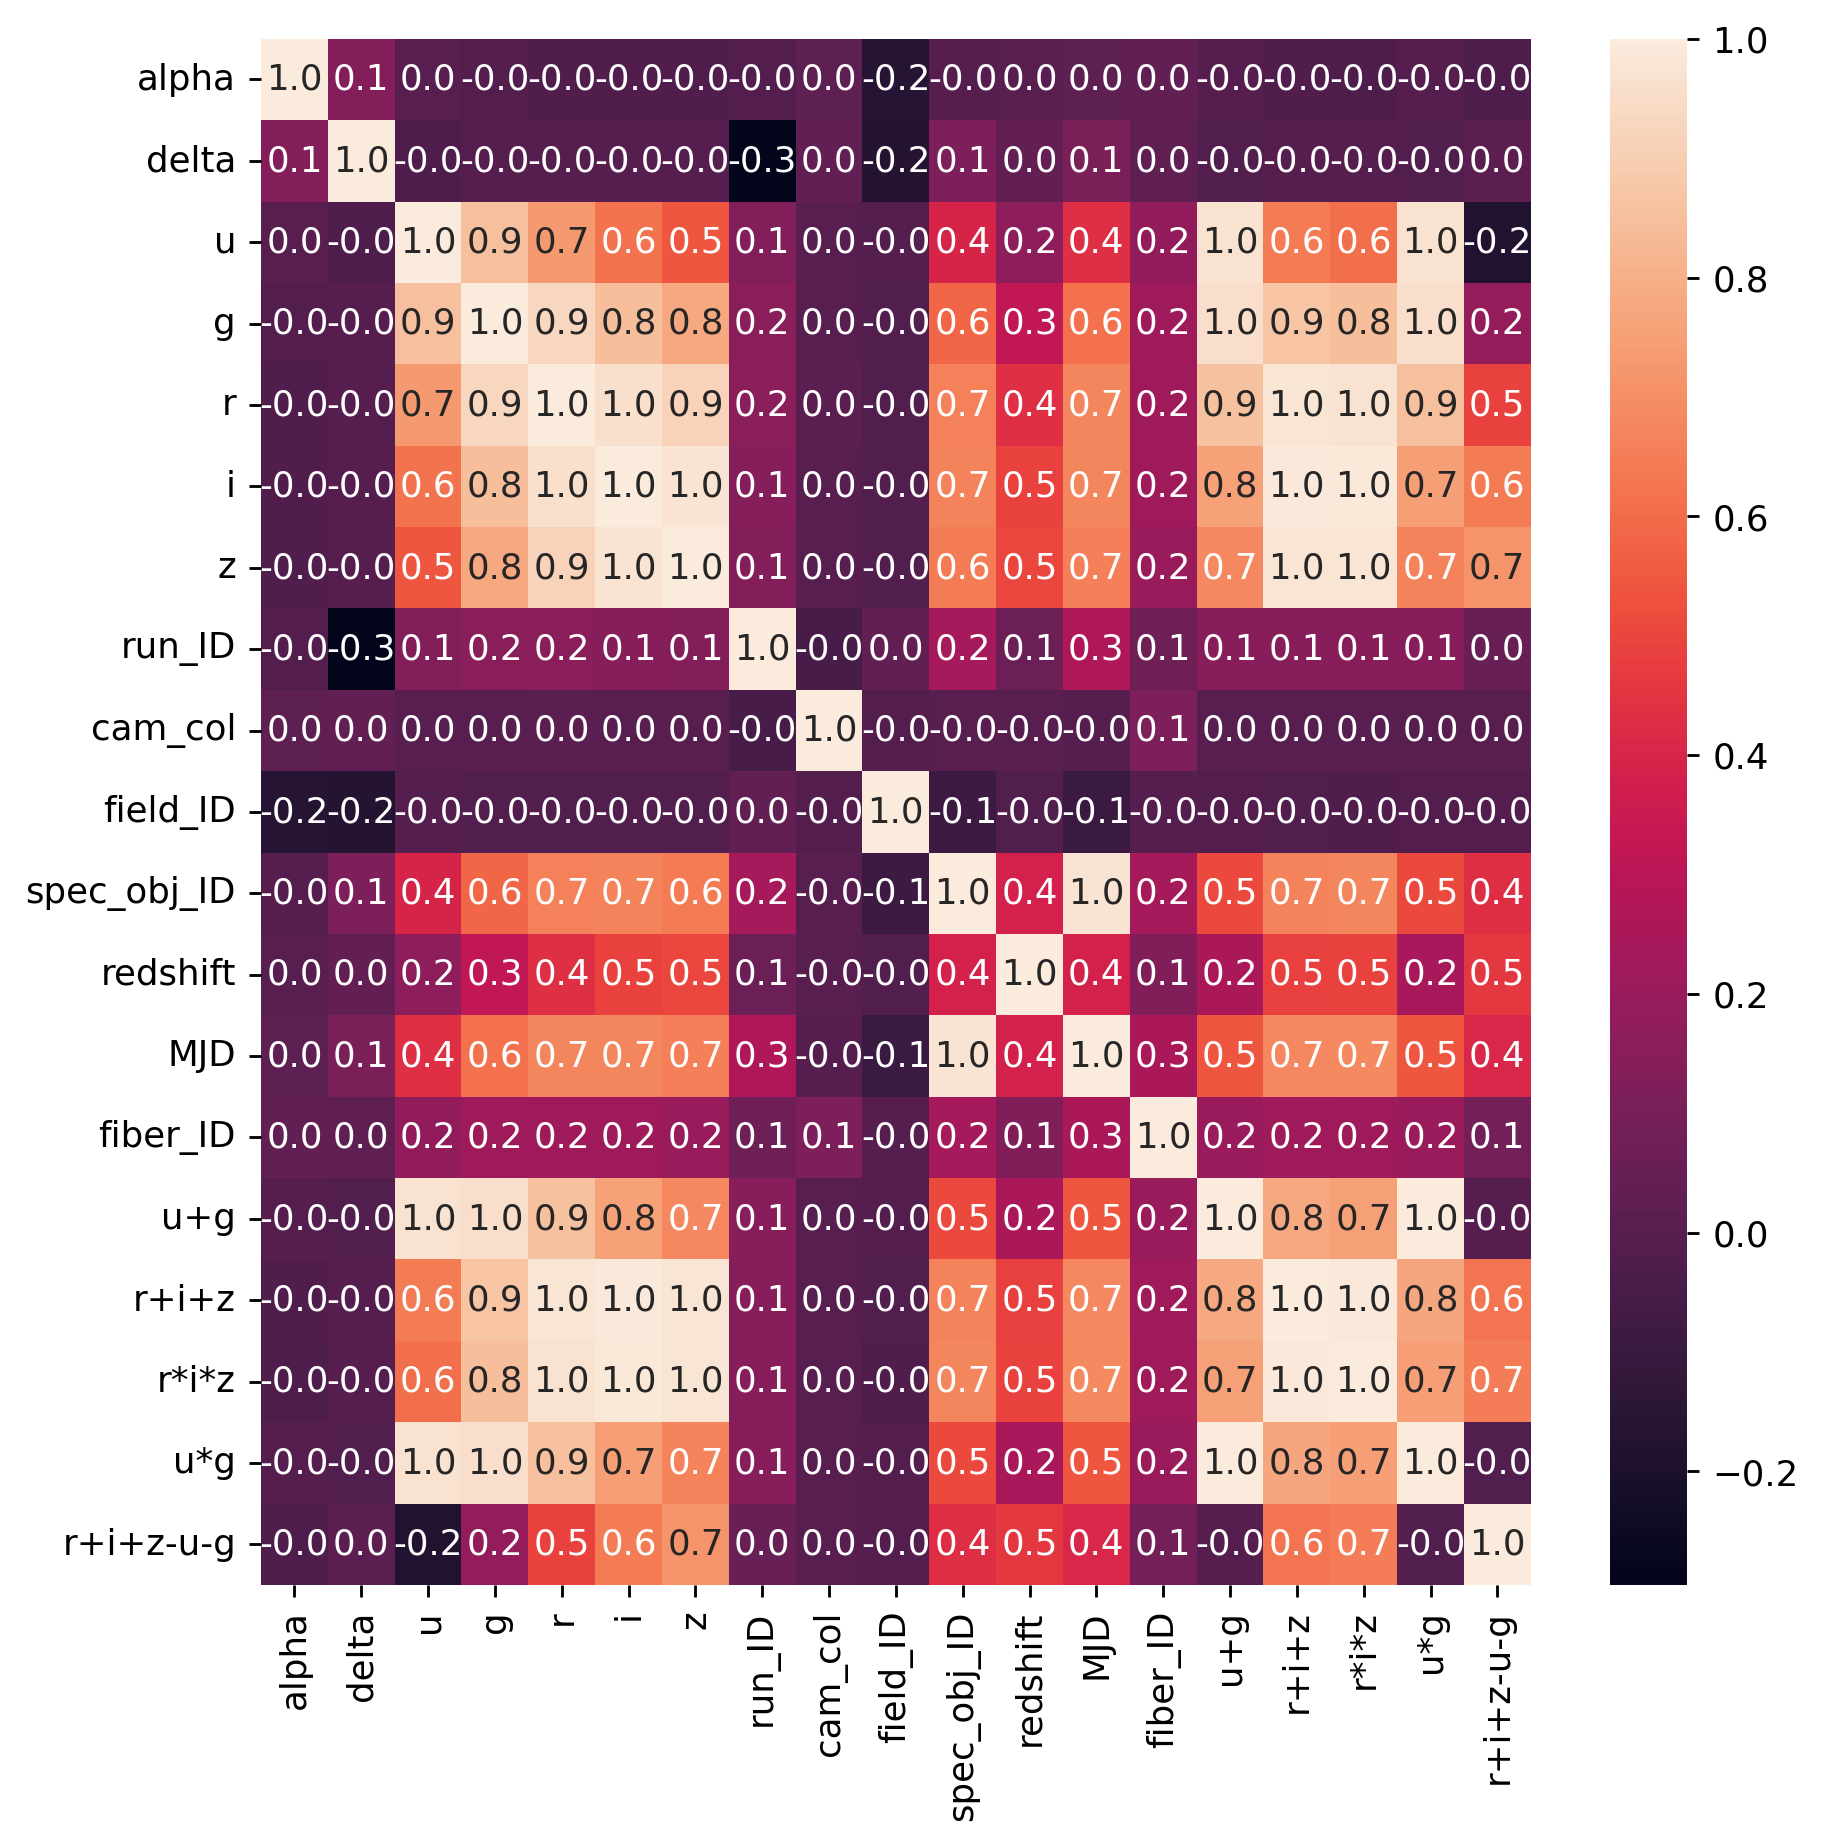

In [22]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test6 = test.copy()

# Modefikowanie cech
df['u+g'] = df[['u', 'g']].sum(axis=1)
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
df['r*i*z'] = df[['r', 'i', 'z']].prod(axis=1)
df['u*g'] = df[['u', 'g']].prod(axis=1)
df['r+i+z-u-g'] = df['r+i+z']-df['u+g']

test6['u+g'] = test6[['u', 'g']].sum(axis=1)
test6['r+i+z'] = test6[['r', 'i', 'z']].sum(axis=1)
test6['r*i*z'] = test6[['r', 'i', 'z']].prod(axis=1)
test6['u*g'] = test6[['u', 'g']].prod(axis=1)
test6['r+i+z-u-g'] = test6['r+i+z']-df['u+g']

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test6[columns_to_normalize] = MinMaxScaler().fit_transform(test6[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID',
                          'u+g', 'r+i+z', 'r*i*z', 'u*g', 'r+i+z-u-g']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test6[columns_to_standardize] = StandardScaler().fit_transform(test6[columns_to_standardize])

df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

### Modefikacja cech opisujących filtry: u, g, r+i+z

In [23]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test7 = test.copy()
# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
test7['r+i+z'] = test7[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test7[columns_to_normalize] = MinMaxScaler().fit_transform(test7[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test7[columns_to_standardize] = StandardScaler().fit_transform(test7[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z'], axis = 1)
test7 = test7.drop(['MJD'], axis = 1)
test7 = test7.drop(['r', 'i', 'z'], axis = 1)

test_models(df, test7, False)

Dokładności modeli:
LogisticRegression 0.9552857142857143
KNeighborsClassifier: 0.9206666666666666
RandomForestClassifier: 0.9724285714285714
DecisionTreeClassifier: 0.9115714285714286
MLPClassifier: 0.9589047619047619


### Modefikacja cech opisujących filtry: u+g, r+i+z

In [24]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test8 = test.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
df['u+g'] = df[['u', 'g']].sum(axis=1)
test8['r+i+z'] = test8[['r', 'i', 'z']].sum(axis=1)
test8['u+g'] = test8[['u', 'g']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test8[columns_to_normalize] = MinMaxScaler().fit_transform(test8[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'u+g', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test8[columns_to_standardize] = StandardScaler().fit_transform(test8[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)
test8 = test8.drop(['MJD'], axis = 1)
test8 = test8.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)

test_models(df, test8, False)

Dokładności modeli:
LogisticRegression 0.9544285714285714
KNeighborsClassifier: 0.9211428571428572
RandomForestClassifier: 0.9724285714285714
DecisionTreeClassifier: 0.9083333333333333
MLPClassifier: 0.9457142857142857


### Modefikacja cech opisujących filtry: u, r+i+z

In [25]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test9 = test.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
test9['r+i+z'] = test9[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test9[columns_to_normalize] = MinMaxScaler().fit_transform(test9[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test9[columns_to_standardize] = StandardScaler().fit_transform(test9[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'g'], axis = 1)
test9 = test9.drop(['MJD'], axis = 1)
test9 = test9.drop(['r', 'i', 'z', 'g'], axis = 1)

test_models(df, test9, False)

Dokładności modeli:
LogisticRegression 0.9533333333333334
KNeighborsClassifier: 0.9186666666666666
RandomForestClassifier: 0.9701428571428572
DecisionTreeClassifier: 0.9072380952380953
MLPClassifier: 0.597047619047619


### Modefikacja cech opisujących filtry: g, r+i+z

In [26]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test10 = test.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
test10['r+i+z'] = test10[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test10[columns_to_normalize] = MinMaxScaler().fit_transform(test10[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test10[columns_to_standardize] = StandardScaler().fit_transform(test10[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u'], axis = 1)
test10 = test10.drop(['MJD'], axis = 1)
test10 = test10.drop(['r', 'i', 'z', 'u'], axis = 1)

test_models(df,test10, False)

Dokładności modeli:
LogisticRegression 0.9542857142857143
KNeighborsClassifier: 0.9239047619047619
RandomForestClassifier: 0.9724761904761905
DecisionTreeClassifier: 0.9067619047619048
MLPClassifier: 0.597047619047619


### Modefikacja cech opisujących filtry: r+i+z

In [27]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test11 = test.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
test11['r+i+z'] = test11[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test11[columns_to_normalize] = MinMaxScaler().fit_transform(test11[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test11[columns_to_standardize] = StandardScaler().fit_transform(test11[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)
test11 = test11.drop(['MJD'], axis = 1)
test11 = test11.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)

test_models(df,test11, False)

Dokładności modeli:
LogisticRegression 0.945952380952381
KNeighborsClassifier: 0.9106190476190477
RandomForestClassifier: 0.9603809523809523
DecisionTreeClassifier: 0.8755714285714286
MLPClassifier: 0.9526190476190476


### Modefikacja cech opisujących filtry: r+i+z-u-g

In [28]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test12 = test.copy()

# Modefikowanie cech
df['r+i+z-u-g'] = df['r']+df['i']+df['z']-df['u']-df['g']
test12['r+i+z-u-g'] = test12['r']+df['i']+df['z']-df['u']-df['g']

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test12[columns_to_normalize] = MinMaxScaler().fit_transform(test12[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z-u-g']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test12[columns_to_standardize] = StandardScaler().fit_transform(test12[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)
test12 = test12.drop(['MJD'], axis = 1)
test12 = test12.drop(['r', 'i', 'z', 'u', 'g'], axis = 1)

test_models(df,test12, False)

Dokładności modeli:
LogisticRegression 0.8970952380952381
KNeighborsClassifier: 0.7804285714285715
RandomForestClassifier: 0.8678095238095238
DecisionTreeClassifier: 0.7922857142857143
MLPClassifier: 0.9043809523809524


## Wybrano cechy opisujące filtry: u, g, r+i+z

### Semantyczny wybór pozostałych cech

Można wywnioskować, że numery identyfikacyjne nie mają pozytywnego wpływu na przewidywania klas obiektów.
Nawet jeśli dokładność modelu się zwiększa, przez istnienie pewnych wzorców historycznych w doborze numerów identyfikacyjnych, to nie mamy pewności, czy podobny trend będzie obecny w przyszłych/innych obserwacjach.

Współrzędne astronomiczne również nie mają znaczącego wpływu pozytywne notowania algorytmu, bo na danym obszarze nieboskłonu rozkład obiektów jest różny. Nawet, jeśli te cechy  zwiększają dokładność na pewnej próbce danych, to jak wyżej, nie mamy pewności, czy podobna tendencja zajdzie dla innego zbioru danych.

Kolumna 'fiber_ID' została odrzucona na podstawie testów - jej wpływ na dane był negatywny (ale w granicach błędu spowodowanego użorzenia się danyc w próbce).

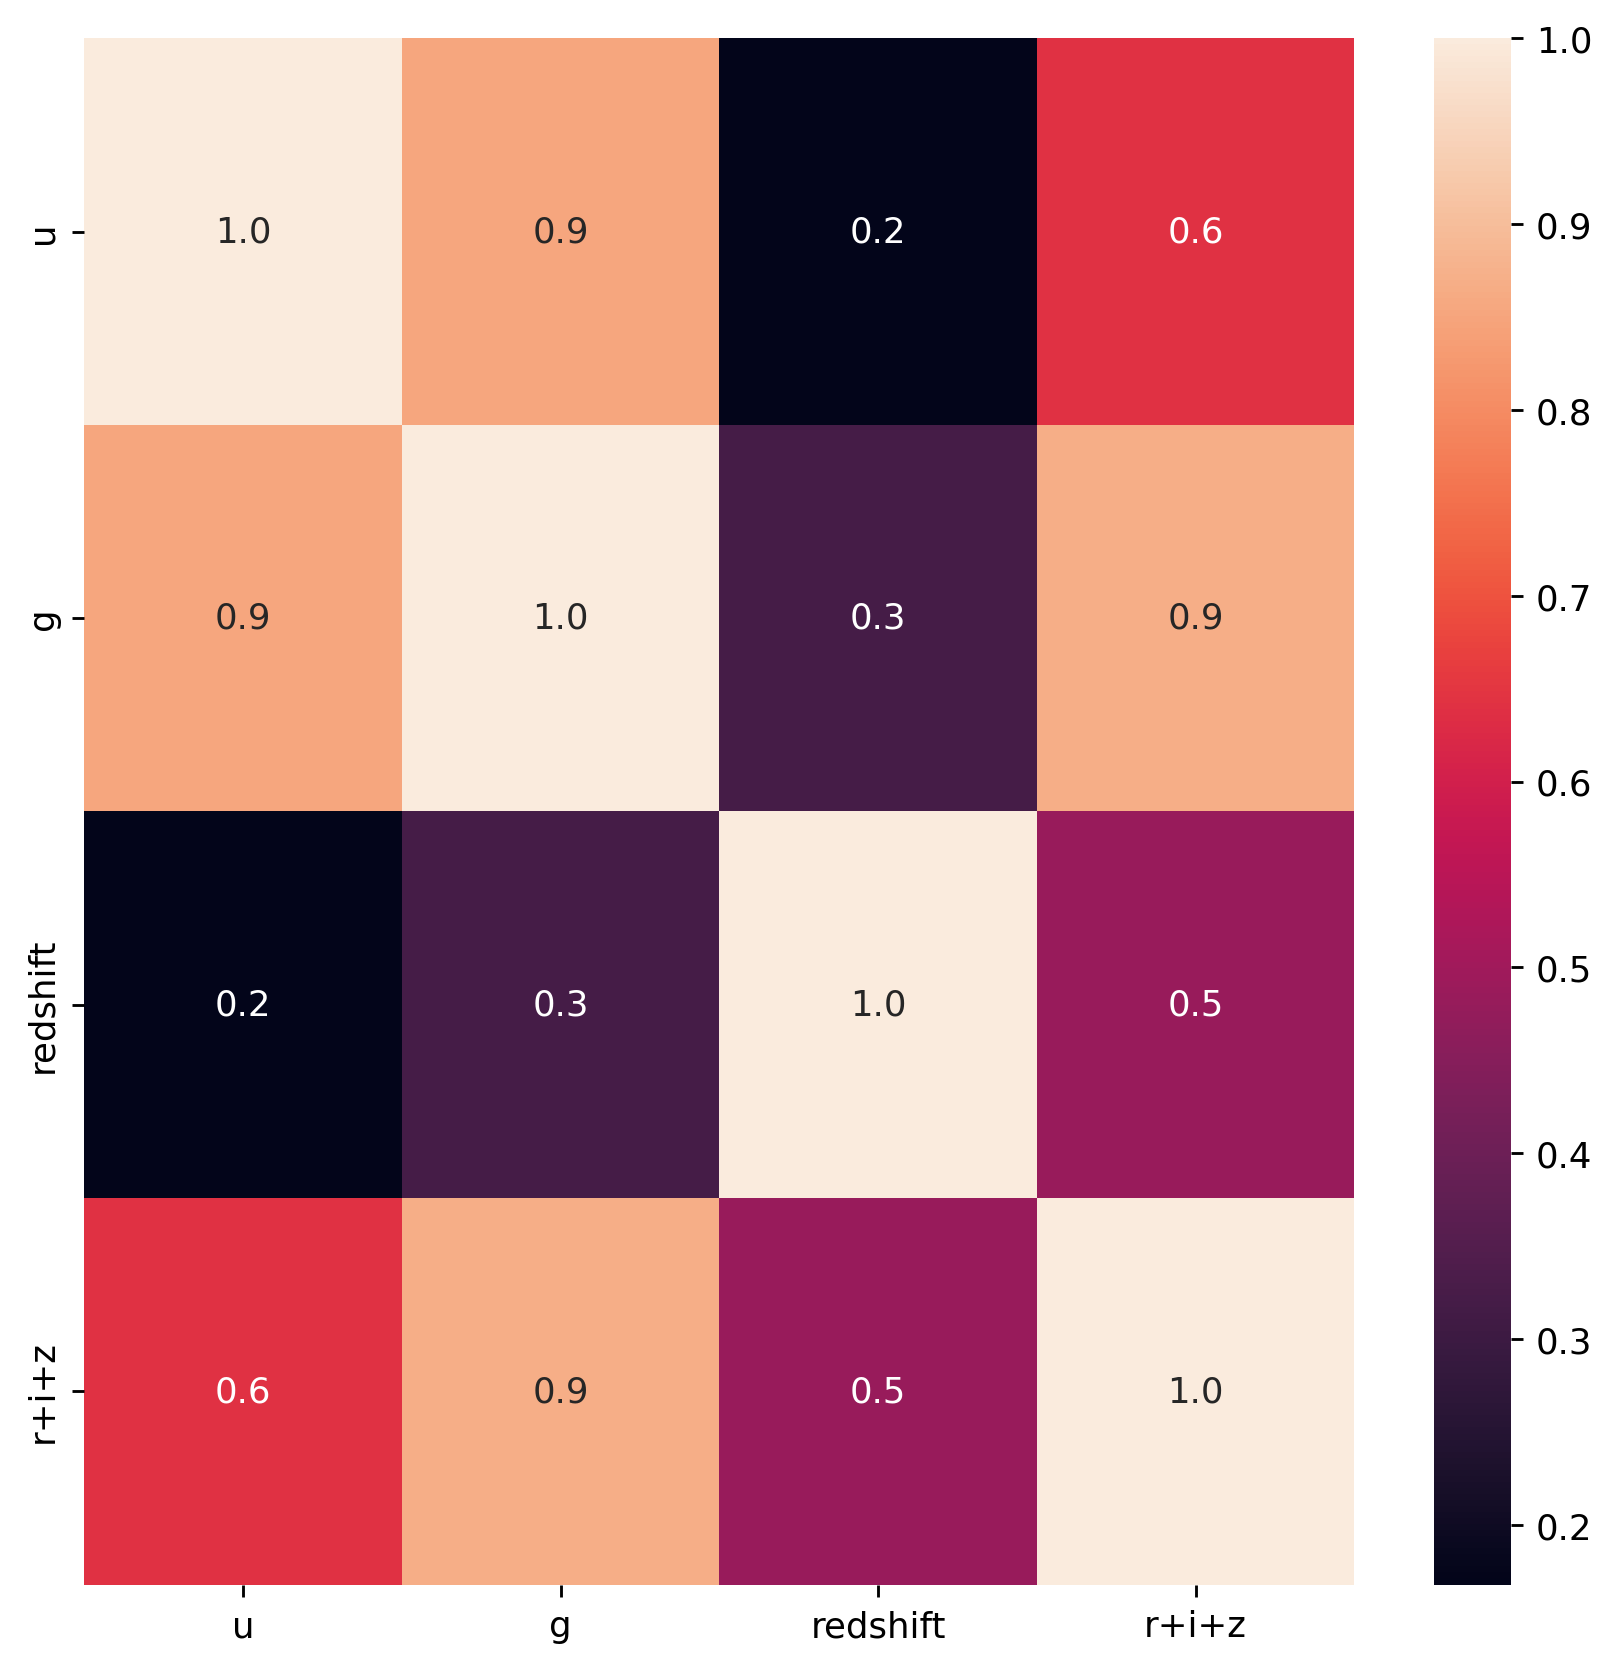

Dokładności modeli:
LogisticRegression 0.9532380952380952
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     12538
         QSO       0.94      0.88      0.91      3973
        STAR       0.94      1.00      0.97      4489

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000

KNeighborsClassifier: 0.9616666666666667
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.93      0.99      0.96      4489

    accuracy                           0.96     21000
   macro avg       0.95      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000

RandomForestClassifier: 0.9636666666666667
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.

In [37]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test13 = test.copy()

# Modefikowanie cech
df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
test13['r+i+z'] = test13[['r', 'i', 'z']].sum(axis=1)

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test13[columns_to_normalize] = MinMaxScaler().fit_transform(test13[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test13[columns_to_standardize] = StandardScaler().fit_transform(test13[columns_to_standardize])


# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['r', 'i', 'z'], axis = 1)
test13 = test13.drop(['MJD'], axis = 1)
test13 = test13.drop(['r', 'i', 'z'], axis = 1)

# Odrzucenie cech na podstawie interpretacji ich znaczenia
df = df.drop(['spec_obj_ID'], axis = 1) # numer obiektu
df = df.drop(['alpha'], axis = 1) # współrzędne astronomiczne
df = df.drop(['delta'], axis = 1) # współrzędne astronomiczne
df = df.drop(['field_ID'], axis = 1) # numer pola ze zdjęcia (fragment zdjęcia)
df = df.drop(['cam_col'], axis = 1) # numer kolumny ze zdjęcia (fragment zdjęcia)
df = df.drop(['run_ID'], axis = 1) # numer zdjęcia
df = df.drop(['fiber_ID'], axis = 1) # numer włókna, które skierowało światło na płaszczyznę ogniskową

test13 = test13.drop(['spec_obj_ID'], axis = 1) # numer obiektu
test13 = test13.drop(['alpha'], axis = 1) # współrzędne astronomiczne
test13 = test13.drop(['delta'], axis = 1) # współrzędne astronomiczne
test13 = test13.drop(['field_ID'], axis = 1) # numer pola ze zdjęcia (fragment zdjęcia)
test13 = test13.drop(['cam_col'], axis = 1) # numer kolumny ze zdjęcia (fragment zdjęcia)
test13 = test13.drop(['run_ID'], axis = 1) # numer zdjęcia
test13 = test13.drop(['fiber_ID'], axis = 1) # numer włókna, które skierowało światło na płaszczyznę ogniskową

df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

test_models(df,test13, True)

In [38]:
test_models_train_on_balanced(df, test13, True)

Dokładności modeli:
LogisticRegression 0.9368571428571428
              precision    recall  f1-score   support

      GALAXY       0.97      0.92      0.95     12538
         QSO       0.86      0.92      0.89      3973
        STAR       0.92      1.00      0.96      4489

    accuracy                           0.94     21000
   macro avg       0.92      0.95      0.93     21000
weighted avg       0.94      0.94      0.94     21000

KNeighborsClassifier 0.951
              precision    recall  f1-score   support

      GALAXY       0.98      0.94      0.96     12538
         QSO       0.89      0.95      0.92      3973
        STAR       0.93      0.99      0.96      4489

    accuracy                           0.95     21000
   macro avg       0.93      0.96      0.95     21000
weighted avg       0.95      0.95      0.95     21000

RandomForestClassifier 0.9664761904761905
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     12538
  

### Test dla cech wybranych na podstawie wartości informacji wzajemnych

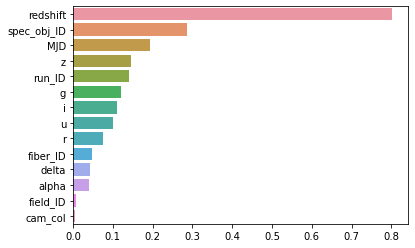

Dokładności modeli:
LogisticRegression 0.9545238095238096
KNeighborsClassifier: 0.9543809523809523
RandomForestClassifier: 0.9711904761904762
DecisionTreeClassifier: 0.9093333333333333
SVC: 0.9596190476190476
MLPClassifier: 0.9615714285714285


In [39]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test15 = test.copy()

# Wykres informacji wzajmenych
scores = pd.Series(mutual_info_classif(df.drop('class', axis = 1), df['class']),
                   index=df.drop('class', axis = 1).columns).sort_values(ascending=False)
sns.barplot(x=scores.values, y=list(scores.index))
plt.show()

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test15[columns_to_normalize] = MinMaxScaler().fit_transform(test15[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test15[columns_to_standardize] = StandardScaler().fit_transform(test15[columns_to_standardize])

# Usuwanie kolumn
df = df.drop(['u','r', 'i','alpha', 'cam_col', 'fiber_ID', 'delta', 'field_ID'], axis = 1)
test15 = test15.drop(['u','r', 'i','alpha', 'cam_col', 'fiber_ID', 'delta', 'field_ID'], axis = 1)

test_models(df,test15, False)

## Wnioski

Najbardziej znaczące cechy to te opisujące użyte filtry (czyli 'u', 'g', 'r', 'i', 'z') i 'redshift'.

Najlepsze wyniki osiąga model lasu losowego.

Klasa STAR jest przewidywana z największą dokładnością.

### Tak z ciekwości (przewidywanie na podstawie dwóch cech)

In [40]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test14 = test.copy()
# Modefikowanie cech

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test14[columns_to_normalize] = MinMaxScaler().fit_transform(test14[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test14[columns_to_standardize] = StandardScaler().fit_transform(test14[columns_to_standardize])

# Usuwanie kolumn
# te zostawiam
# ['u', 'redshift']
# te wyrzucam
df = df.drop(['run_ID', 'spec_obj_ID', 'MJD', 'alpha', 'cam_col', 'fiber_ID'], axis = 1)
df = df.drop(['g','r', 'i', 'z', 'delta', 'field_ID'], axis = 1)
test14 = test14.drop(['run_ID', 'spec_obj_ID', 'MJD', 'alpha', 'cam_col', 'fiber_ID'], axis = 1)
test14 = test14.drop(['g','r', 'i', 'z', 'delta', 'field_ID'], axis = 1)

test_models(df,test14, False)

Dokładności modeli:
LogisticRegression 0.9502380952380952
KNeighborsClassifier: 0.9620952380952381
RandomForestClassifier: 0.955952380952381
DecisionTreeClassifier: 0.9035238095238095
SVC: 0.9541904761904761
MLPClassifier: 0.9584285714285714


In [41]:
test_models_train_on_balanced(df,test14, False)

Dokładności modeli:
LogisticRegression 0.937952380952381
KNeighborsClassifier 0.9506190476190476
RandomForestClassifier 0.9523333333333334
DecisionTreeClassifier 0.9208095238095239
SVC: 0.9492857142857143
MLPClassifier: 0.21376190476190476


### Tak z ciekwości (przewidywanie na podstawie jednej cechy)

In [42]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()
test14 = test.copy()
# Modefikowanie cech

# Normalizacja
columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])
test14[columns_to_normalize] = MinMaxScaler().fit_transform(test14[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])
test14[columns_to_standardize] = StandardScaler().fit_transform(test14[columns_to_standardize])

# Usuwanie kolumn
# te zostawiam
# ['redshift']
# te wyrzucam
df = df.drop(['u', 'run_ID', 'spec_obj_ID', 'MJD', 'alpha', 'cam_col', 'fiber_ID'], axis = 1)
df = df.drop(['g','r', 'i', 'z', 'delta', 'field_ID'], axis = 1)
test14 = test14.drop(['u', 'run_ID', 'spec_obj_ID', 'MJD', 'alpha', 'cam_col', 'fiber_ID'], axis = 1)
test14 = test14.drop(['g','r', 'i', 'z', 'delta', 'field_ID'], axis = 1)

test_models(df,test14, False)

Dokładności modeli:
LogisticRegression 0.9377619047619048
KNeighborsClassifier: 0.942047619047619
RandomForestClassifier: 0.8676190476190476
DecisionTreeClassifier: 0.8675714285714285
SVC: 0.9439047619047619
MLPClassifier: 0.9479047619047619


In [43]:
test_models_train_on_balanced(df,test14, False)

Dokładności modeli:
LogisticRegression 0.9179047619047619
KNeighborsClassifier 0.9207619047619048
RandomForestClassifier 0.8366190476190476
DecisionTreeClassifier 0.8366190476190476
SVC: 0.936
MLPClassifier: 0.9361428571428572
